In [5]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

In [6]:
# results_dir = "results/multiview_experiments_0.6M_BMIMI_RandomForestClassifier"
# results_dir = "results/multiview_experiments_0.7M_BMIMTfO_RandomForestClassifier"
# results_dir = "results/multiview_experiments_0.9M_BMIMBr_RandomForestClassifier"
# results_dir = "results/multiview_experiments_1.2M_BMIMCl_RandomForestClassifier"
# results_dir = "results/multiview_experiments_avgfp_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BG_STRSQ_Abate2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Ostermeier2014_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Palzkikll2012_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Ranganathan2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BLAT_ECOLX_Tenaillon2013-singles_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BRCA1_HUMAN_Fields2015_e3_RandomForestClassifier"
# results_dir = "results/multiview_experiments_BRCA1_HUMAN_Fields2015_y2h_RandomForestClassifier"
# results_dir = "results/multiview_experiments_DLG4_RAT_Ranganathan2012_RandomForestClassifier"
# results_dir = "results/multiview_experiments_GAL4_YEAST_Shendure2015_RandomForestClassifier"
# results_dir = "results/multiview_experiments_HG_FLU_Bloom2016_RandomForestClassifier"
# results_dir = "results/multiview_experiments_HSP82_YEAST_Bolon2016_RandomForestClassifier"

results_dir = "results/multiview_experiments_avgfp_RandomForestClassifier"
#results_dir = "results/multiview_experiments_avgfp_LogisticRegression"

In [71]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", "ProtVec"]
# Get list of tuples from combinations
labeled_sizes = [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
#labeled_sizes = [0.15, 0.1, 0.05]
comb = list(combinations(encodings, 2))

In [72]:
global_pred_dict = dict()

for enc1, enc2 in comb:
    global_pred_dict[f"cotraining-{enc1}-{enc2}"] = dict()
    global_pred_dict[f"cotraining-{enc2}-{enc1}"] = dict()
    global_pred_dict[enc1] = dict()
    global_pred_dict[enc2] = dict()
    global_pred_dict["concat-"+enc1+"-"+enc2] = dict()
    global_pred_dict["concat-"+enc2+"-"+enc1] = dict()
    global_pred_dict["st-lr-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-lr-"+enc2+"-"+enc1] = dict()
    global_pred_dict["st-mean-"+enc1+"-"+enc2] = dict()
    global_pred_dict["st-mean-"+enc2+"-"+enc1] = dict()

    for labeled_size in labeled_sizes:
        with open(f'{results_dir}/pred_dict_ct_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict[f"cotraining-{enc1}-{enc2}"][labeled_size] = data
            global_pred_dict[f"cotraining-{enc2}-{enc1}"][labeled_size] = data
        with open(f'{results_dir}/pred_dict_{enc1}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc1][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_{enc2}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc2][labeled_size] = pkl.load(f)
        with open(f'{results_dir}/pred_dict_concat_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["concat-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["concat-"+enc2+"-"+enc1][labeled_size] = data
        with open(f'{results_dir}/pred_dict_st_lr_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["st-lr-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["st-lr-"+enc2+"-"+enc1][labeled_size] = data
        with open(f'{results_dir}/pred_dict_st_mean_{enc1}_{enc2}_{labeled_size}.pickle', 'rb') as f:
            data = pkl.load(f)
            global_pred_dict["st-mean-"+enc1+"-"+enc2][labeled_size] = data
            global_pred_dict["st-mean-"+enc2+"-"+enc1][labeled_size] = data

# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'Train_size', 'View', 'AUC'])
for view_combination, labeled_sizes in global_pred_dict.items():
    for labeled_size, preds_list in labeled_sizes.items():
        for preds in preds_list:
            # if view.startswith("st-lr-"):
            #     y_proba = 1 -preds["y_proba"]
            # else:
            #     y_proba = preds["y_proba"]
            y_proba = preds["y_proba"]
            original_y_test = preds["original_y_test"]
            y_test = preds["y_test"]
            train_size = preds["train_len"]
            auc = roc_auc_score(y_test, y_proba)
            spearman_r = spearmanr(original_y_test, y_proba)[0]
            weighted_tau = weightedtau(original_y_test, y_proba)[0]
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'View': view_combination, 
                                              'AUC': auc, 
                                              'Spearman_r': spearman_r,
                                              'Weighted_tau': weighted_tau}, index=[0])], ignore_index=True)

In [81]:
def get_one_vs_all_results(df, metric, encodings, view_combination, views):
    # Read times best from pkl for each results folder (each pair of encodings)
    one_vs_all_dict = dict()

    # Shape of the dictionary pickled is:
    # cotraining_vs_best_dict -> labeled_percentage -> mean (5foldCV) difference from cotraining auc to best

    # Getting mean results from kfold
    for enc1, enc2 in permutations(encodings, 2):
        one_vs_all_dict[(enc1, enc2)] = dict()
        # one_vs_all_dict[(enc2, enc1)] = dict()
        for labeled_percentage in df['Labeled'].unique():
            means = dict()
            means["CoTraining"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"cotraining-{enc1}-{enc2}")][metric].mean()
            means["View1"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc1)][metric].mean()
            means["View2"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == enc2)][metric].mean()
            means["Concat"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"concat-{enc1}-{enc2}")][metric].mean()
            means["Stacking-lr"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-lr-{enc1}-{enc2}")][metric].mean()
            means["Stacking-mean"] = df.loc[(df['Labeled'] == labeled_percentage) & (df['View'] == f"st-mean-{enc1}-{enc2}")][metric].mean()

            # Get the difference between means[view] and the maximum of the rest of the values of the dictionary
            one_vs_all_dict[(enc1, enc2)][labeled_percentage] = means[view_combination] - max([means[rival] for rival in views if rival != view_combination])
    return one_vs_all_dict

In [82]:
def create_heatmap_dict(one_vs_all_dict, labeled, view_combination, plot=False):

    heatmap_dict = {}

    for encodings, results in one_vs_all_dict.items():
        enc1, enc2 = encodings
        heatmap_dict[(enc1, enc2)] = results[labeled]

    ser = pd.Series(list(heatmap_dict.values()),
                    index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
    heatmap_df = ser.unstack().fillna(0)
    
    # Set new column and index order
    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based

    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                    "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                    "Evolution": ['PAM250', 'BLOSUM62'],
                    "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                    "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}

    new_index_order = new_columns_order
    heatmap_df = heatmap_df.reindex(new_index_order, axis=0)
    heatmap_df = heatmap_df.reindex(new_columns_order, axis=1)
    # Fill nans with 0
    heatmap_df = heatmap_df.fillna(0)

    if plot:
        # Set heatmap limits to 1 and 0
        # Hide heatmap legend
        sns.heatmap(heatmap_df, cmap="RdYlGn", center=0)#, vmin=-0.1, vmax=0.1)
        # Group heatmap columns by group
        for group, encodings in groups_dict.items():
            plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
            plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
            plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
            
        # Set title
        plt.title(f'{view_combination} being best | {labeled*100}% labeled)', fontsize=14)
        plt.show()
    return heatmap_df

In [83]:
from matplotlib.patches import Patch
def create_heatmap_dict_all_vs_all(one_vs_all_dict, labeled):
    cmap1 = sns.light_palette("green", as_cmap=True)
    cmap1.set_under('none')
    cmap2 = sns.light_palette("blue", as_cmap=True)
    cmap2.set_under('none')
    cmap3 = sns.light_palette("red", as_cmap=True)
    cmap3.set_under('none')
    cmap4 = sns.light_palette("yellow", as_cmap=True)
    cmap4.set_under('none')
    cmap5 = sns.light_palette("purple", as_cmap=True)
    cmap5.set_under('none')
    cmap6 = sns.light_palette("orange", as_cmap=True)
    cmap6.set_under('none')

    
    data1 = one_vs_all_dict["CoTraining"]
    data2 = one_vs_all_dict["View1"]
    data3 = one_vs_all_dict["View2"]
    data4 = one_vs_all_dict["Concat"]
    data5 = one_vs_all_dict["Stacking-lr"]
    data6 = one_vs_all_dict["Stacking-mean"]

    new_columns_order = ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', # Binary
                        'Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors', # Physicochemical properties
                        'PAM250', 'BLOSUM62', # Evolution-based
                        'Miyazawa_energies', 'Micheletti_potentials', # Structure-based 
                        'AESNN3', 'ANN4D', 'ProtVec']   # Machine learning-based
    groups_dict = {"Binary": ['One_hot', 'One_hot_6_bit', 'Binary_5_bit'],
                  "Physicochemical": ['Hydrophobicity_matrix', 'Meiler_parameters', 'Acthely_factors'],
                  "Evolution": ['PAM250', 'BLOSUM62'],
                  "Structure": ['Miyazawa_energies', 'Micheletti_potentials'],
                  "Machine learning": ['AESNN3', 'ANN4D', 'ProtVec']}
    
    # Vmax to highest value of all heatmaps
    vmax = max(data1.max().max(), data2.max().max(), data3.max().max(), data4.max().max(), data5.max().max(), data6.max().max())

    # Fig size bigger
    plt.figure(figsize=(15, 5))
    
    ax1 = sns.heatmap(data1, vmin=0.0000001, vmax=vmax, cmap=cmap1, cbar_kws={'pad': -0.06})
    sns.heatmap(data2, vmin=0.0000001, vmax=vmax, cmap=cmap2, cbar_kws={'pad': -0.05})
    sns.heatmap(data3, vmin=0.0000001, vmax=vmax, cmap=cmap3, cbar_kws={'pad': -0.04})
    sns.heatmap(data4, vmin=0.0000001, vmax=vmax, cmap=cmap4, cbar_kws={'pad': -0.03})
    sns.heatmap(data5, vmin=0.0000001, vmax=vmax, cmap=cmap5, cbar_kws={'pad': -0.02})
    sns.heatmap(data6, vmin=0.0000001, vmax=vmax, cmap=cmap6)
    # Group heatmap columns by group
    for group, encodings in groups_dict.items():
        plt.axvline(x=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.axhline(y=new_columns_order.index(encodings[0]), color='black', linewidth=1)
        plt.text(x=-10, y=new_columns_order.index(encodings[-1])-1, s=group, rotation=0, fontsize=8)
    plt.title(f'Best view | {labeled*100}% labeled)', fontsize=14)

    # Legend with colors
    legend_elements = [Patch(facecolor=cmap1(1000), edgecolor='black', label='CoTraining'),
                          Patch(facecolor=cmap2(1000), edgecolor='black', label='View1'),
                            Patch(facecolor=cmap3(1000), edgecolor='black', label='View2'),
                            Patch(facecolor=cmap4(1000), edgecolor='black', label='Concat'),
                            Patch(facecolor=cmap5(1000), edgecolor='black', label='Stacking-lr'),
                            Patch(facecolor=cmap6(1000), edgecolor='black', label='Stacking-mean')]
    plt.legend(handles=legend_elements, loc=(1, 50), bbox_to_anchor=(1.01, 1.01), fontsize=10)
       
    
    plt.show()

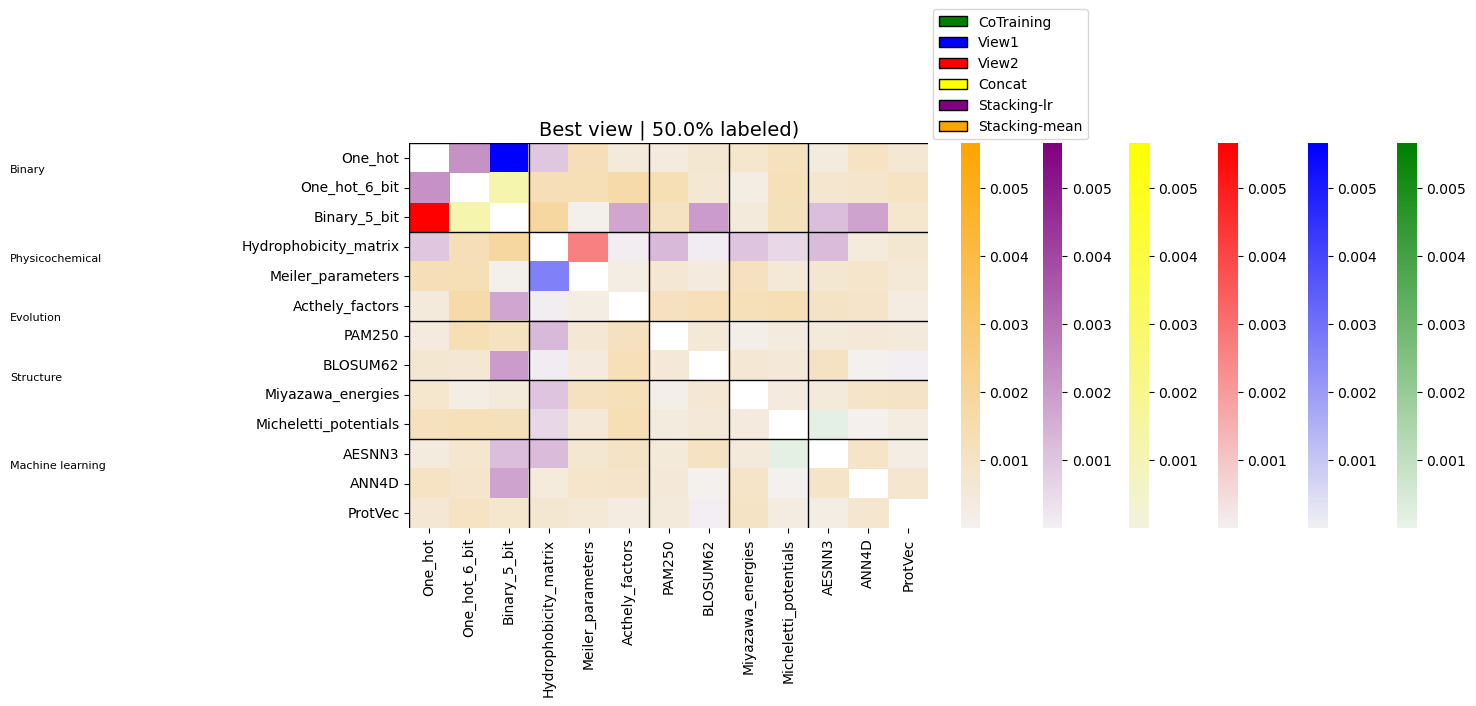

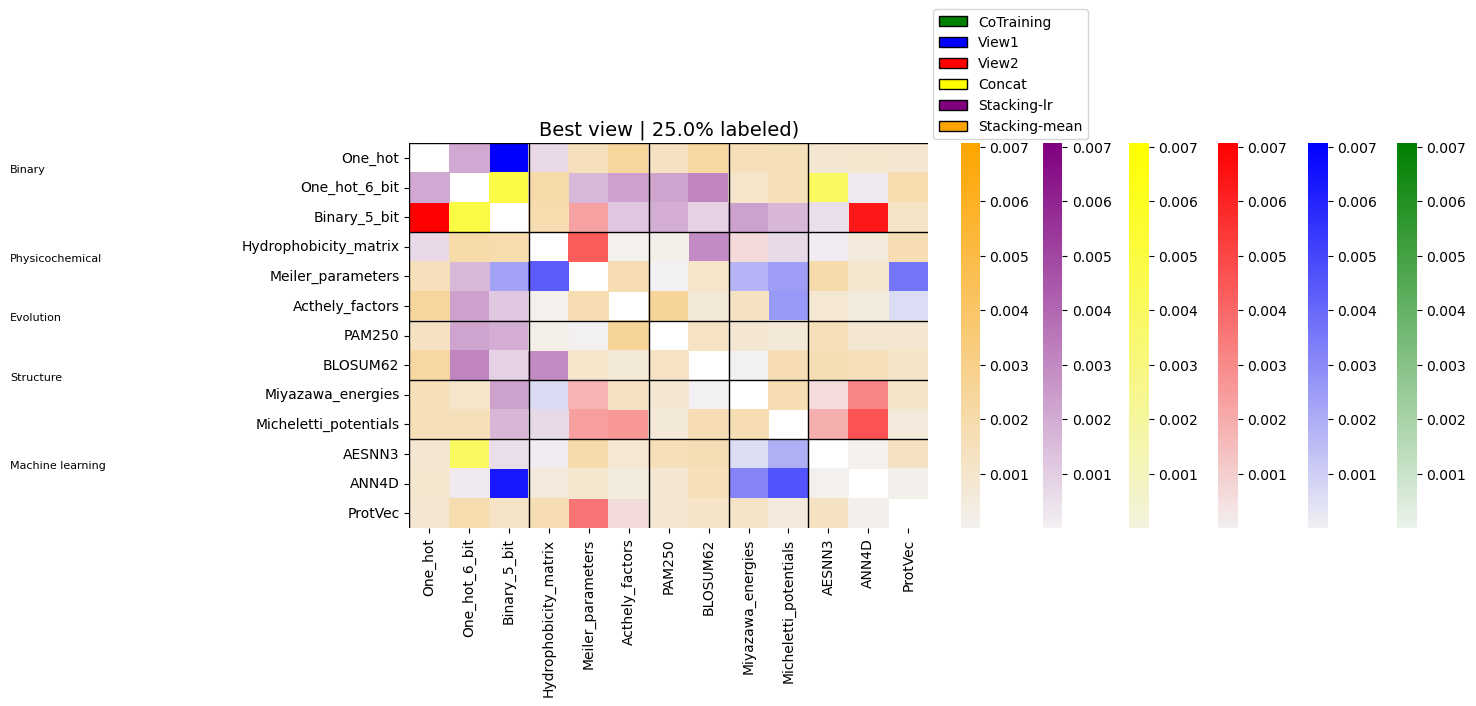

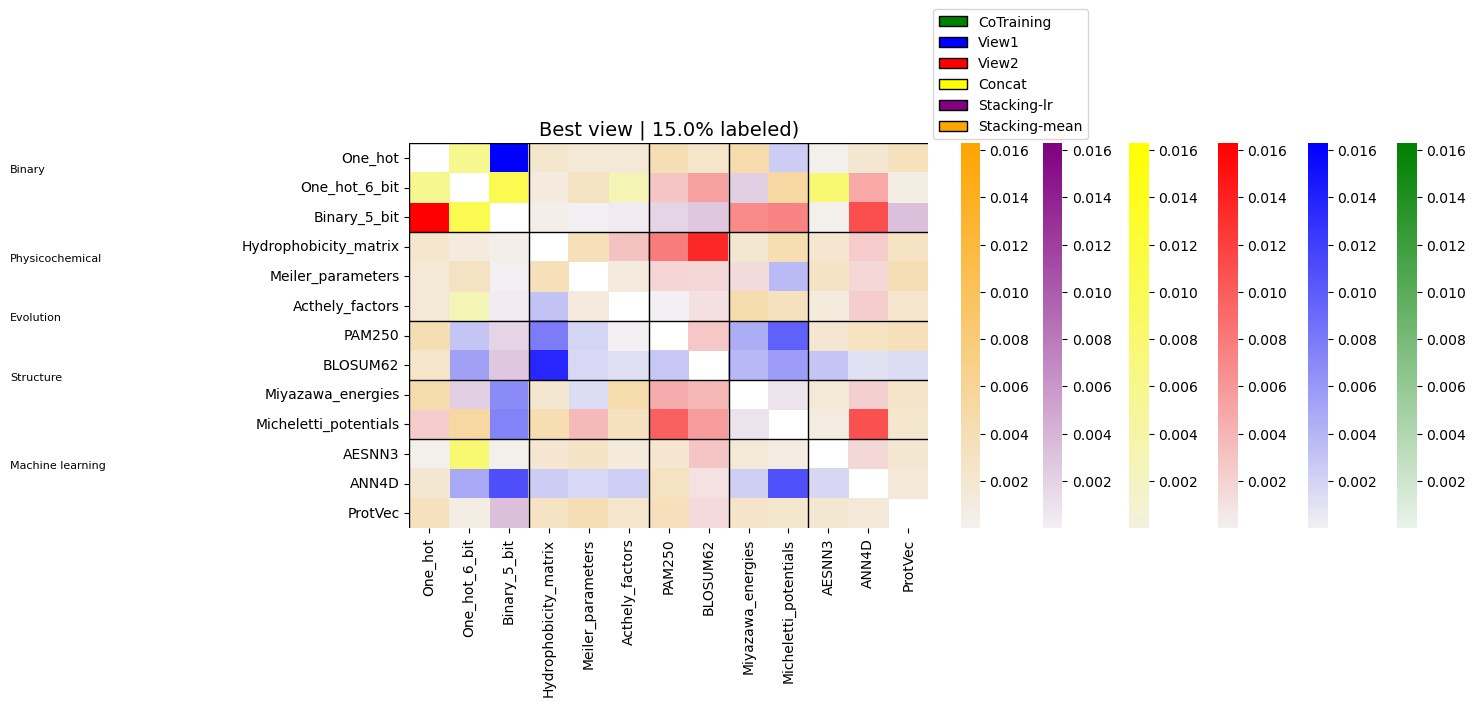

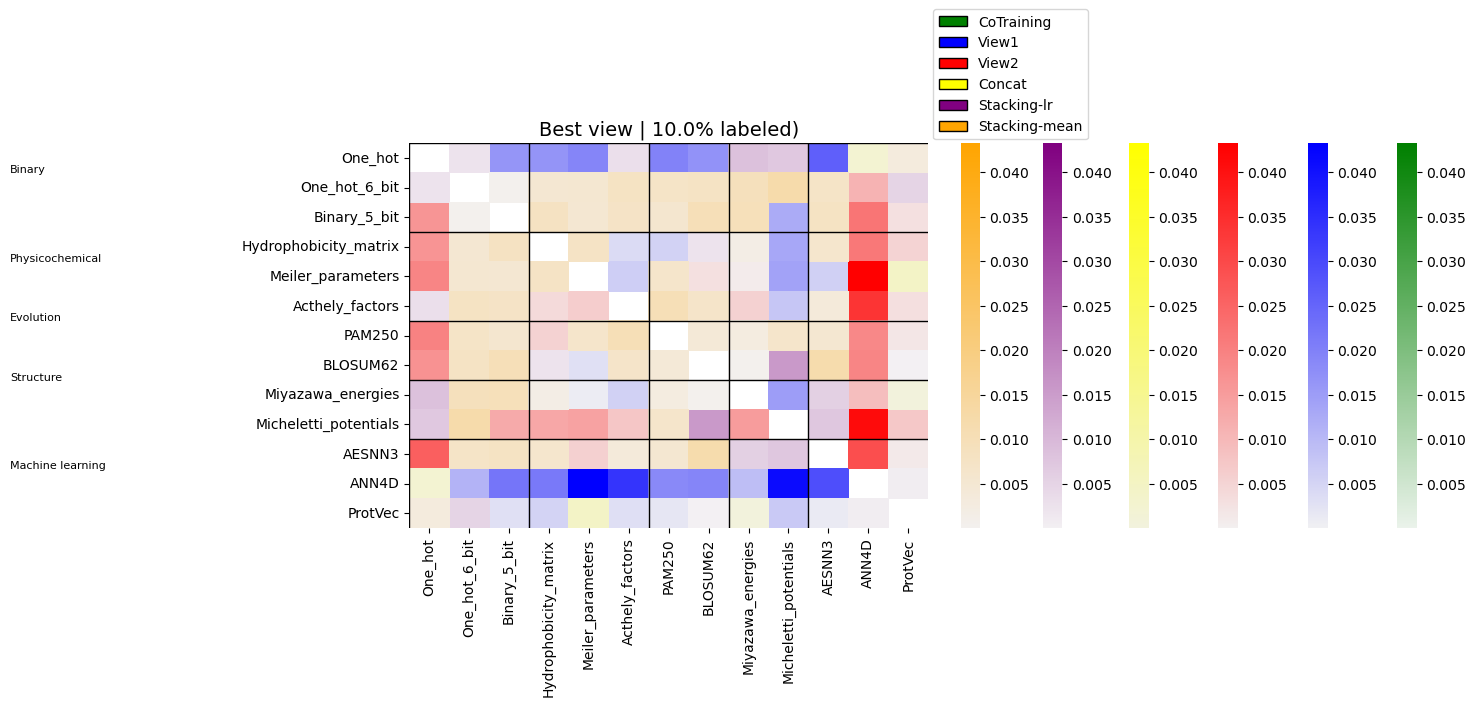

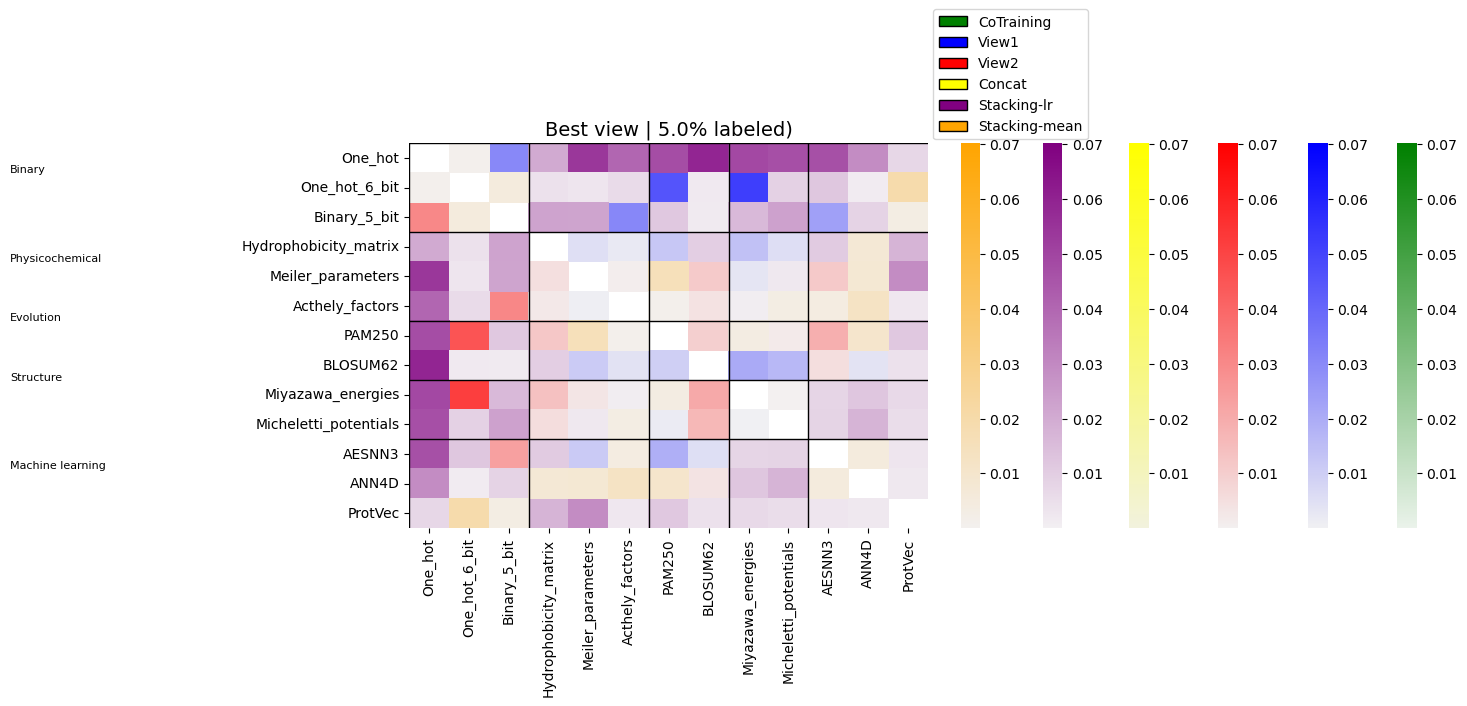

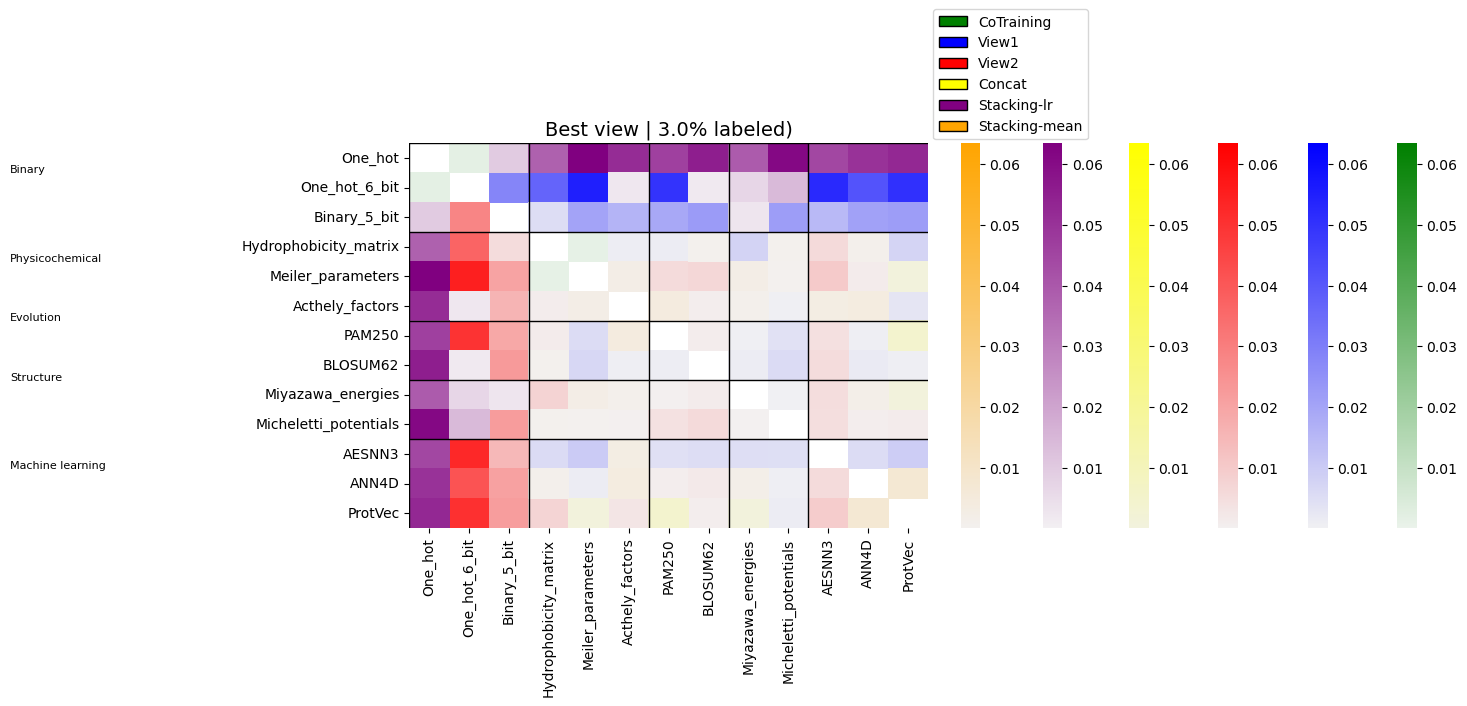

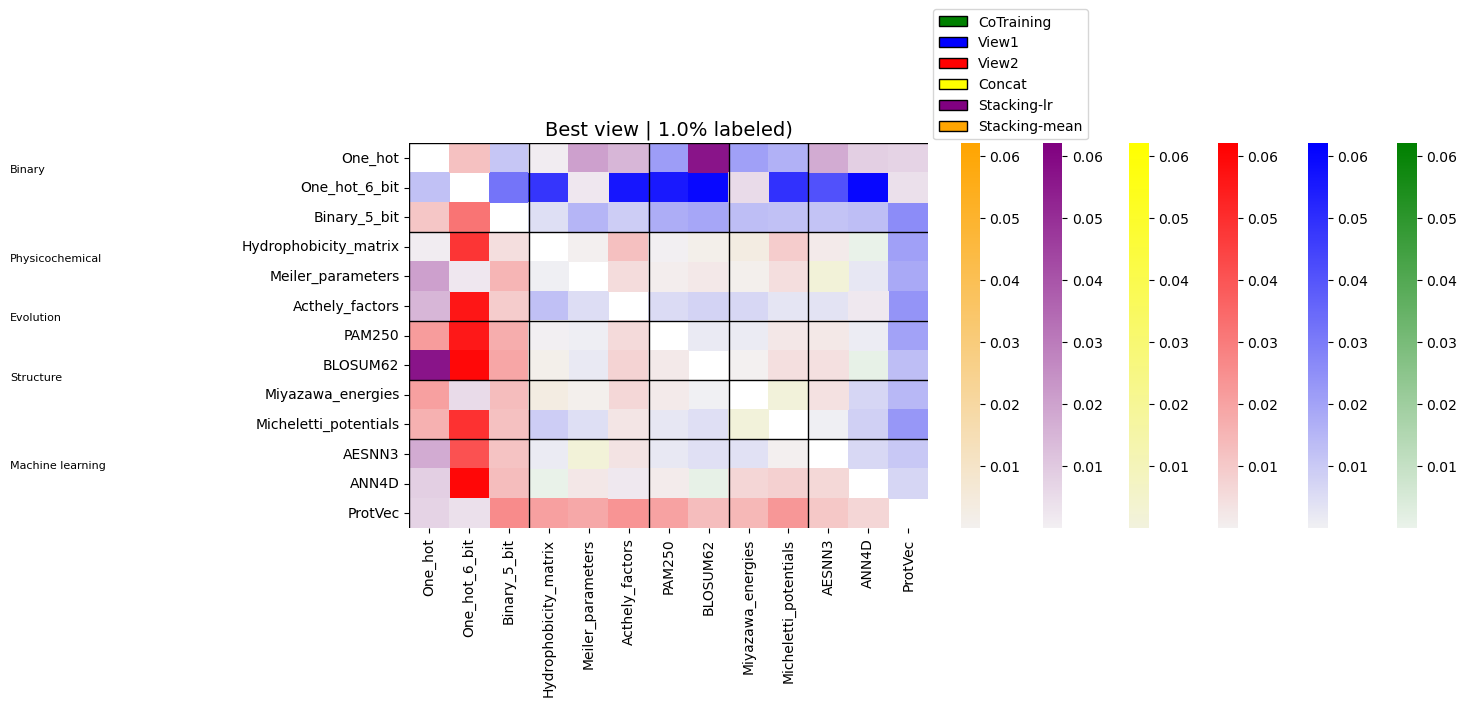

In [85]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
# labeled_sizes =  [0.1]
for labeled_size in labeled_sizes:
    
    #view = "Concat" 
    view = "Stacking-lr"
    
    #views =  ["CoTraining", "Concat", "View1", "View2"]
    views =  ["CoTraining", "Concat", "Stacking-mean", "View1", "View2"]
    
    one_vs_all_dict = {}
    one_vs_all_dict["CoTraining"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "CoTraining", views), labeled_size, "CoTraining")
    one_vs_all_dict["View1"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "View1", views), labeled_size, "View1")
    one_vs_all_dict["View2"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "View2", views), labeled_size, "View2")
    one_vs_all_dict["Concat"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "Concat", views), labeled_size, "Concat")
    one_vs_all_dict["Stacking-lr"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "Stacking-lr", views), labeled_size, "Stacking-lr")
    one_vs_all_dict["Stacking-mean"] = create_heatmap_dict(get_one_vs_all_results(df, "AUC", encodings, "Stacking-mean", views), labeled_size, "Stacking-mean")
   
    
    create_heatmap_dict_all_vs_all(one_vs_all_dict, labeled_size)


In [86]:
labeled_sizes =  [0.5, 0.25, 0.15, 0.1, 0.05, 0.03, 0.01]
for labeled_size in labeled_sizes:
    # CoTraining, Concat, Stacking-lr, Stacking-mean, View1 or View2
    
    #view = "Concat" 
    view = "Stacking-lr"
    
    #views =  ["CoTraining", "Concat", "View1", "View2"]
    views =  ["CoTraining", "Concat", "Stacking-mean", "View1", "View2"]
    
    #one_vs_all_dict = get_one_vs_all_results(df, "AUC", encodings, view, views) 
    one_vs_all_dict = get_one_vs_all_results(df, "Spearman_r", encodings, view, views) 
    create_heatmap_dict(one_vs_all_dict, labeled_size, view)


# Boxplots for a encoding pair

In [ ]:
# selected_metric = "AUC"
# selected_metric = "Spearman_r"
selected_metric = "Weighted_tau"

/tmp/ipykernel_3276602/3650694484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3276602/3650694484.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


Text(0.5, 1.0, 'One_hot vs Micheletti_potentials | Weighted_tau by view | 5-fold CV')

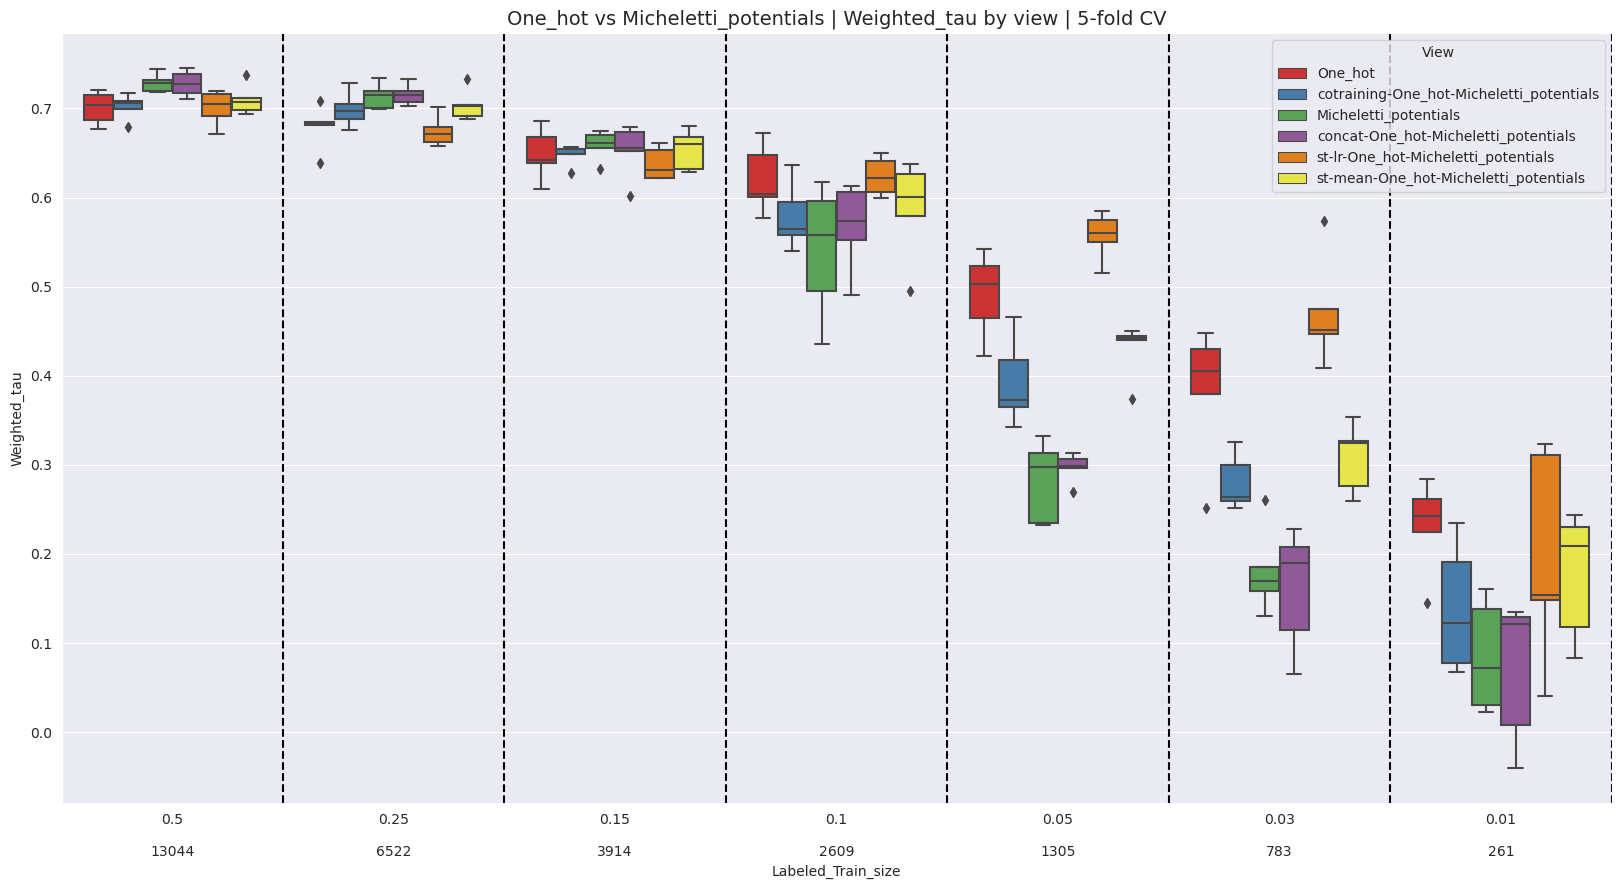

In [ ]:
enc1 = 'One_hot'
enc2 = 'Micheletti_potentials'
#for enc1, enc2 in combinations(encodings, 2):
# Boxplot for folds aucs
plt.figure(figsize=(20, 10))

boxplot_df = df.loc[(df['View'] == f"cotraining-{enc1}-{enc2}") | (df['View'] == enc1) | (df['View'] == enc2) | (df['View'] == f"concat-{enc1}-{enc2}") | (df['View'] == f"st-lr-{enc1}-{enc2}") | (df['View'] == f"st-mean-{enc1}-{enc2}")]
boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'View'])['Train_size'].transform('mean').round(0).astype(int)
boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)
# Boxplot grouped by labeled
# Vertical and horizontal grid background
sns.set_style("darkgrid")
# Add underscore at the beginning of every instance in view column in boxplot_df
# pointplot_df = boxplot_df.copy()
# pointplot_df["View"] = pointplot_df['View'].apply(lambda x: f"_{x}")
# ax = sns.pointplot(data=pointplot_df, x='Labeled', y='AUC', 
#                     hue='View', ci=None, linestyles=":",
#                     dodge=.8-0.8/4, scale=0.8, markers="",
#                     palette="Set1")
#plt.setp(ax.lines, zorder=0)
sns.boxplot(x="Labeled_Train_size", y=selected_metric, hue="View", data=boxplot_df, palette="Set1")
[plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
plt.title(f'{enc1} vs {enc2} | {selected_metric} by view | 5-fold CV', fontsize=14)
#plt.gca().invert_xaxis()

# Ranking of encoding couples for each labeled percentage

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Rank df by AUC mean grouped by view and labeled
    display(df.loc[(df["Labeled"] == 0.10)].groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))
    display(df.groupby(['View', 'Labeled']).mean().sort_values(by=['Labeled', 'AUC'], ascending=False))

,,AUC,Spearman_r,Weighted_tau
View,Labeled,,,
st-lr-One_hot_6_bit-ProtVec,0.1,0.846270,0.680200,0.653314
concat-Meiler_parameters-ProtVec,0.1,0.843742,0.662360,0.671561
st-lr-One_hot-ProtVec,0.1,0.842533,0.671378,0.659817
st-mean-One_hot-ProtVec,0.1,0.842435,0.677264,0.662227
st-lr-ANN4D-ProtVec,0.1,0.841466,0.651574,0.672663
concat-One_hot_6_bit-ProtVec,0.1,0.841186,0.660306,0.671360
st-lr-BLOSUM62-ProtVec,0.1,0.841082,0.653347,0.661345
concat-BLOSUM62-ProtVec,0.1,0.840939,0.655886,0.663723
concat-ANN4D-ProtVec,0.1,0.840862,0.651504,0.678420


,,AUC,Spearman_r,Weighted_tau
View,Labeled,,,
st-lr-One_hot_6_bit-ANN4D,0.50,0.883326,0.742868,0.712960
st-lr-One_hot-One_hot_6_bit,0.50,0.883304,0.758069,0.694541
st-mean-One_hot-PAM250,0.50,0.882879,0.742173,0.713375
st-mean-One_hot-BLOSUM62,0.50,0.882859,0.741752,0.713183
st-lr-One_hot-BLOSUM62,0.50,0.882598,0.741563,0.707297
st-lr-One_hot-PAM250,0.50,0.882579,0.742370,0.709905
st-mean-One_hot-ANN4D,0.50,0.882539,0.741331,0.715407
st-mean-One_hot-Meiler_parameters,0.50,0.882512,0.740230,0.712569
cotraining-One_hot-PAM250,0.50,0.882469,0.741490,0.711835
